<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [1]:
!pip3.5 install xgboost
!pip3.5 install shap

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.5'
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "12g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.types import *
from pyspark.sql import Row


import shap
import xgboost as xgb
from scipy.sparse import csr_matrix

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.


Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [3]:
DATA_PATH = '/workspace/data/criteo'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

In [4]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [5]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [6]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [7]:
df = df.sample(False, 0.5)

In [8]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [9]:
PIPELINE_MODEL_PATH = '../../sgd_logreg_nn/notebooks/transforming_pipeline'

pipeline_model = PipelineModel.load(PIPELINE_MODEL_PATH)

In [10]:
pipeline_model.stages

[StringIndexer_fa5879c7ff96,
 StringIndexer_0bd13a7c534c,
 OneHotEncoderEstimator_b79d5461c2c6,
 VectorAssembler_c2be7e771af8,
 MinMaxScaler_55ed6422bf30,
 VectorAssembler_92261c67a29c]

In [ ]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

Итоговая размерность пространства фичей

In [ ]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

In [ ]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

In [ ]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [15]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [16]:
first_train_df, first_val_df, frist_test_df = train_df, val_df, test_df

model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [17]:
path = os.path.join(DATA_PATH, 'xgb.model')
if os.path.exists(path):
    os.remove(path)

model._call_java("booster").saveModel(path)

### Evaluation

In [18]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [42]:
def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows correspond to metrics, cols correspond to models and ATE with respect to control)
    """
    
    metrics_df = pd.DataFrame(list(groups.values()), index=list(groups.keys()))
    return ((metrics_df - metrics_df.loc[control_name]) / metrics_df.loc[control_name]).T

In [43]:
rocauc(model, val_df, probabilities_col='probabilities')

NameError: name 'model' is not defined

In [44]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

NameError: name 'model' is not defined

In [ ]:
all_metrics['xgb_baseline'] = baseline_metrics

In [23]:
get_ate(all_metrics, 'xgb_baseline')

,xgb_baseline
ROC AUC,0.0


Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [24]:
log_reg_model_path = os.path.join(DATA_PATH, 'log_reg_model')
log_reg_model = LogisticRegressionModel.load(log_reg_model_path)
log_reg_model

LogisticRegressionModel: uid = LogisticRegression_701fe75bc368, numClasses = 2, numFeatures = 1941

Построить таблицу ATE используя метод `get_ate`

In [25]:
log_reg_metrics = {}
log_reg_metrics['ROC AUC'] = rocauc(log_reg_model, val_df, probabilities_col='probability')

all_metrics['log_reg'] = log_reg_metrics
all_metrics

{'log_reg': {'ROC AUC': 0.702802039018601},
 'xgb_baseline': {'ROC AUC': 0.7283014579287151}}

In [26]:
get_ate(all_metrics, 'xgb_baseline')

,log_reg,xgb_baseline
ROC AUC,-0.035012,0.0


## New Model
### Prepare Data

In [27]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.sample(False, 0.5)
df = df.fillna(0, subset=num_columns)

In [28]:
df.limit(5).toPandas().loc[:,'_c9':]

,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,...,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39,id
0,4,0,4,0,0,241546e0,38a947a1,fa673455,6a14f9b9,25c83c98,...,e5f8f18f,None,None,f3ddd519,None,32c7478e,b34f3128,None,None,12
1,88,3,4,12,4,05db9164,08d6d899,333440d5,fc86bde0,25c83c98,...,bbf70d82,None,None,16e2e3b3,None,32c7478e,d859b4dd,None,None,41
2,4,0,0,0,5,68fd1e64,207b2d81,74e1a23a,9a6888fb,25c83c98,...,25935396,21ddcdc9,5840adea,99c09e97,None,be7c41b4,335a6a1e,001f3601,8d8eb391,108
3,28,0,1,0,0,05db9164,38d50e09,c86b2d8d,657dc3b9,25c83c98,...,fffe2a63,21ddcdc9,b1252a9d,eb0fc6f8,None,32c7478e,df487a73,001f3601,c27f155b,117
4,177,1,7,0,11,5a9ed9b0,942f9a8d,013bceb0,136ff514,25c83c98,...,1f868fdd,cd11c728,a458ea53,00680113,None,32c7478e,ad4c56a0,e8b83407,8270b5de,121


#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [32]:
# Fitted Model
class MeanTargetEncoderModel(
    pyspark.ml.Model, DefaultParamsReadable, DefaultParamsWritable
):
    def __init__(self, input_col, substitution_df):
        super(MeanTargetEncoderModel, self).__init__()
        self.input_col    = input_col
        self.substitution_df = substitution_df.cache()
    
    def transform(self, df):
        return df.join(self.substitution_df, self.input_col, how='left')


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):
    def __init__(self, inputCol, targetCol, featuresCol):
        super(MeanTargetEncoder, self).__init__()
        self.input_col    = inputCol
        self.target_col   = targetCol
        self.features_col = featuresCol
        self.alpha        = 1.
    
    def fit(self, df):
        d = 1. / 0.2564
        
        target_values = df \
            .groupby(self.input_col) \
            .agg(F.count(self.input_col).alias('target_count'),
                 F.sum(self.target_col).alias('target_sum')) \
            .withColumn(self.features_col, 
                        (F.col('target_sum') + self.alpha) / (F.col('target_count') + self.alpha * d)) \
            .drop('target_count', 'target_sum')
        
        substitution_df = target_values.select(self.input_col, self.features_col)
        return MeanTargetEncoderModel(self.input_col, substitution_df)

In [9]:
model = MeanTargetEncoder(inputCol='_c14', targetCol='_c0', featuresCol='_c14_mean_target').fit(df)

#### Pipeline

In [31]:
cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [32]:
pipeline_model = pipeline.fit(df)

# saving ain't work (I have added those interfaces but still not working)
# pipeline_model.save(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [33]:
# from pyspark.ml import PipelineModel

# pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model_2'))

In [34]:
df.count()

1833745

In [35]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1833745

In [36]:
df.first()

Row(label=0, features=DenseVector([0.0, 31.0, 1.0, 1.0, 22579.0, 0.0, 0.0, 1.0, 110.0, 0.0, 0.0, 0.0, 1.0, 0.2489, 0.2266]), id=249108408425)

### Train

Train XGBoost on the new set of features

In [37]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

model = estimator.fit(train_df)

In [38]:
rocauc(model, val_df, probabilities_col='probabilities')

0.735498071035528

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [39]:
######################################
######### YOUR CODE HERE #############
######################################

# Features Importance

## [SHAP](https://github.com/slundberg/shap)

In [40]:
df = first_train_df

In [41]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- id: long (nullable = true)



In [42]:
# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(os.path.join(DATA_PATH, 'xgb.model'))

[20:38:19] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [43]:
print(bst.get_dump()[0])

0:[f0<0.999998987] yes=1,no=2,missing=2
	1:[f5<9.29332527e-05] yes=3,no=4,missing=3
		3:[f10<0.0128195127] yes=7,no=8,missing=7
			7:[f4<3.57390491e-06] yes=15,no=16,missing=15
				15:[f1492<2.00000095] yes=31,no=32,missing=32
					31:[f0<0.00121112121] yes=63,no=64,missing=64
						63:leaf=0.118348636
						64:leaf=0.280253172
					32:[f1388<2.00000095] yes=65,no=66,missing=66
						65:[f5<2.58380715e-05] yes=127,no=128,missing=127
							127:[f3<0.00364198722] yes=249,no=250,missing=249
								249:leaf=0.0828269497
								250:leaf=0.160714284
							128:[f11<0.0138451532] yes=251,no=252,missing=252
								251:leaf=0.132876724
								252:leaf=-0.00458015269
						66:[f5<2.58380715e-05] yes=129,no=130,missing=129
							129:[f3<0.00364198722] yes=253,no=254,missing=253
								253:leaf=-0.0328661688
								254:leaf=0.0343156271
							130:[f3<0.0127494549] yes=255,no=256,missing=256
								255:leaf=-0.0814559162
								256:leaf=-0.0344922245
				16:[f12<0.000424170052] yes=33,no

In [44]:
sample_df = df.sample(False, 0.05)
sample_df.count()

73255

In [45]:
def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    max_idx = 0
    for i, vec in enumerate(sparse_vecs):
        for idx, val in zip(vec.indices, vec.values):
            max_idx = max(max_idx, idx)
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
    print(max_idx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [46]:
dim

1941

In [47]:
%%time
X = df_to_csr(sample_df, dim)
dtest = xgb.DMatrix(X)

1916
CPU times: user 3.54 s, sys: 71 ms, total: 3.61 s
Wall time: 6.48 s


In [48]:
prediction = bst.predict(dtest, pred_leaf=True)

print("shape={} max_leaf_index={}".format(prediction.shape, np.max(prediction)))
prediction

shape=(73255, 20) max_leaf_index=472


array([[169, 317, 395, ..., 194, 278, 204],
       [430, 413, 413, ..., 294, 212, 222],
       [331, 341, 387, ..., 334, 282, 198],
       ...,
       [439, 430, 393, ..., 334, 196, 204],
       [346, 348, 412, ..., 334, 282, 222],
       [444, 432, 296, ..., 167, 185, 234]], dtype=int32)

In [49]:
X.shape

(73255, 1941)

In [50]:
X_arr = X.toarray()

In [51]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 2min 28s, sys: 740 ms, total: 2min 29s
Wall time: 39.2 s


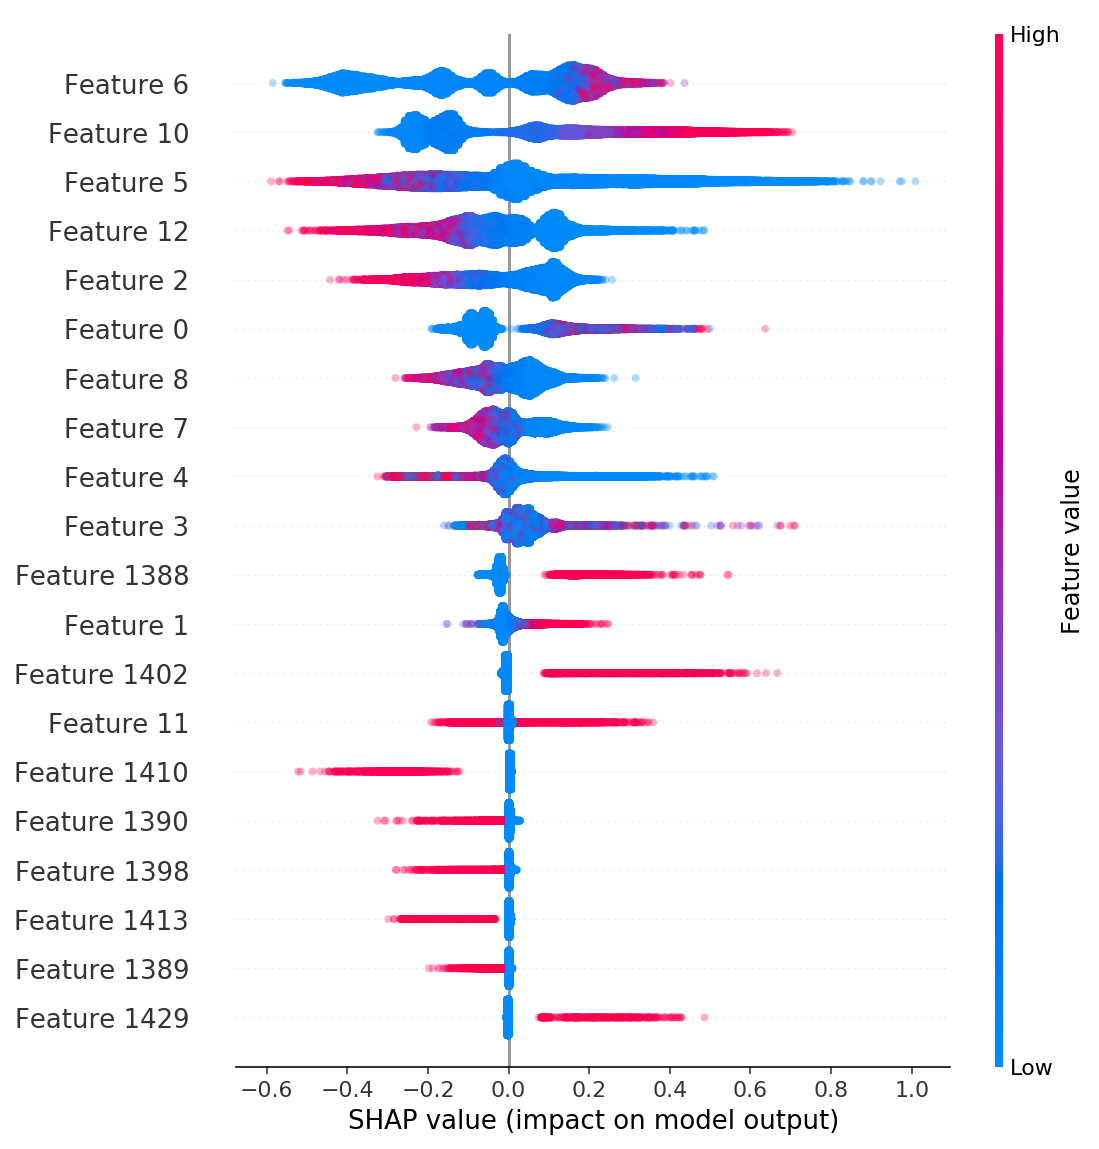

In [52]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [53]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [54]:
f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

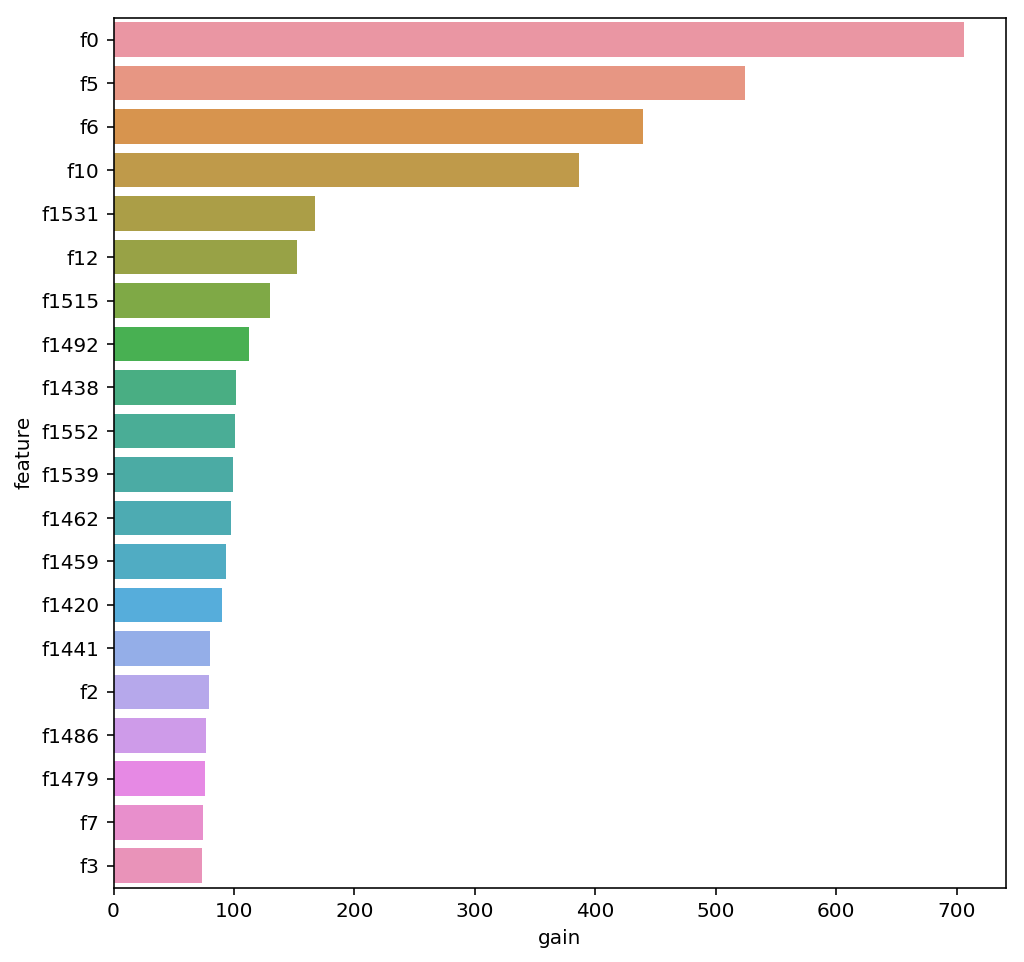

In [55]:
_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

### LogReg over XGBoost

In [47]:
def df_to_csr(df):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    dim = len(sparse_vecs[0])
    
    for i, vec in enumerate(sparse_vecs):
        for idx, val in enumerate(vec.values):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

# Regressor for raw df
class Logistic_Regressor_over_XGBoost:
    def __init__(self):
        self.xgb_estimator = XGBoostEstimator(
            featuresCol="features", 
            labelCol="label", 
            predictionCol="prediction",
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        self.num_columns = num_columns = ['_c{}'.format(i) for i in range(1, 14)]
        self.xgb_estimator_path = os.path.join(DATA_PATH, 'xgb_mean_target.model')
        self.linear_model = LogisticRegression(featuresCol = 'leaf_features', labelCol = 'label', maxIter=10)
        self.pipeline_model = None
        self.max_leaf = None
    
    def fit(self, train_df):
        cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]
        mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

        assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")
        
        pipeline = Pipeline(stages=mean_target_encoders + [assembler])
        self.pipeline_model = pipeline.fit(train_df)
        
        train_df = self.__prepare_df(train_df) \
            .select(F.col('_c0').alias('label'), 'features', 'id') \
            .cache()
        
        self.xgb_estimator = self.xgb_estimator.fit(train_df)
        self.__save_xgb_estimator(self.xgb_estimator)
        
        train_df_with_leafs = self.__add_leaf_features(train_df)
        self.linear_model = self.linear_model.fit(train_df_with_leafs)
    
    def transform(self, df):
        return self.predict(df)
        
    def predict(self, df):
        df = self.__prepare_df(df) \
            .cache()
        
        df_with_leafs = self.__add_leaf_features(df)
        df_with_leafs.persist()
        
        return self.linear_model.transform(df_with_leafs)
        
    def __save_xgb_estimator(self, estimator):
        path = self.xgb_estimator_path
        if os.path.exists(path):
            os.remove(path)
        estimator._call_java("booster").saveModel(path)
        
    def __add_leaf_features(self, df):
        booster = xgb.Booster()
        booster.load_model(self.xgb_estimator_path)
        
        X = df_to_csr(df)
        
        dmatrix = xgb.DMatrix(X)
        leaf_sets = booster.predict(dmatrix, pred_leaf=True)
        
        if self.max_leaf is None:
            self.max_leaf = np.max(leaf_sets)
            
        def to_sparse_vector(leafs):
            leafs = np.unique(np.sort(leafs))
            return Vectors.sparse(self.max_leaf + 1, leafs, np.ones_like(leafs, dtype=np.double))
        
        num_partitions = 15
        sparse_vectors = sc.parallelize([to_sparse_vector(leafs) for leafs in leaf_sets], num_partitions)
        df_rdd         = sc.parallelize(df.rdd.collect(), num_partitions)
        
        def add_leaf_field(p):
            row, leafs = p
            row_dict = row.asDict()
            row_dict['leaf_features'] = leafs
            return Row(**row_dict)
        rdd_extended = df_rdd.zip(sparse_vectors).map(add_leaf_field)
        return spark.createDataFrame(rdd_extended)
        
    def __prepare_df(self, df):
        assert self.pipeline_model is not None
        
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)

### XGBoost + Mean Target

In [39]:
# Regressor for raw df
class XGB_Regressor_MeanTarget:
    def __init__(self):
        self.estimator = XGBoostEstimator(
            featuresCol="features", 
            labelCol="label", 
            predictionCol="prediction",
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
        self.num_columns = ['_c{}'.format(i) for i in range(1, 14)]
        self.pipeline_model = None
    
    def fit(self, train_df):
        cat_columns = ['_c14', '_c15']
        cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]
        mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]
        print("mean target encoding ...")
        assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")
        
        pipeline = Pipeline(stages=mean_target_encoders + [assembler])
        self.pipeline_model = pipeline.fit(train_df)
        
        train_df = self.__prepare_df(train_df) \
            .select(F.col('_c0').alias('label'), 'features', 'id') \
            .cache()
        
        print("fitting xgboost ...")
        self.estimator = self.estimator.fit(train_df)
    
    def transform(self, df):
        return self.predict(df)
        
    def predict(self, df):
        df = self.__prepare_df(df)
        predictions = self.estimator.transform(df)
        
        return predictions
        
    def __prepare_df(self, df):
        assert self.pipeline_model is not None
        
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)

### LogReg baseline

In [40]:
# Regressor for raw df
class LogisticRegressor:
    def __init__(self):
        self.pipeline_model = PipelineModel.load(PIPELINE_MODEL_PATH)
        self.linear_model = LogisticRegression(featuresCol = 'features', labelCol = '_c0', maxIter=10)
        self.num_columns = num_columns = ['_c{}'.format(i) for i in range(1, 14)]
    
    def fit(self, train_df):
        train_df = self.__prepare_df(train_df).select('_c0', 'features', 'id')
        self.linear_model = self.linear_model.fit(train_df)
        
    def transform(self, df):
        return self.predict(df)
        
    def predict(self, df):
        df = self.__prepare_df(df)
        predictions = self.linear_model.transform(df)
        get_second_element = F.udf(lambda v:float(v[1]),FloatType())
        
        return predictions
        
    def __prepare_df(self, df):
        df = df.fillna(0, subset=self.num_columns) 
        return self.pipeline_model.transform(df)

## Prepare Data

In [24]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.sample(0.12)

In [25]:
train, val, test = split_by_col(df, 'id', [0.8, 0.1, 0.1])

## Evaluation

In [26]:
def calibration(model, df):
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    pass

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [27]:
all_metrics = {}

In [37]:
test = test.withColumnRenamed('_c0', 'label')

In [33]:
regressor = LogisticRegressor()
regressor.fit(train)
all_metrics['LogReg'] = {'ROC AUC' : rocauc(regressor, test, probabilities_col='probability')}

In [41]:
regressor = XGB_Regressor_MeanTarget()
regressor.fit(train)
all_metrics['XGBoost+MeanTarget'] = {'ROC AUC' : rocauc(regressor, test, probabilities_col='probabilities')}

mean target encoding ...
fitting xgboost ...


In [46]:
get_ate(all_metrics, 'LogReg')

,LogReg,XGBoost+MeanTarget
ROC AUC,0.0,0.046998


In [48]:
regressor = Logistic_Regressor_over_XGBoost()
regressor.fit(train)

[00:44:47] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [49]:
all_metrics['LogReg over XGBoost'] = {'ROC AUC': rocauc(regressor, test, probabilities_col='probability')}

[00:49:32] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [51]:
all_metrics

{'LogReg': {'ROC AUC': 0.6973151303246555},
 'LogReg over XGBoost': {'ROC AUC': 0.698860918702435},
 'XGBoost+MeanTarget': {'ROC AUC': 0.7300876005309522}}

In [50]:
get_ate(all_metrics, 'LogReg')

,LogReg over XGBoost,LogReg,XGBoost+MeanTarget
ROC AUC,0.002217,0.0,0.046998


### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.

In [ ]:
train_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

TEST_PATH  = os.path.join(DATA_PATH, 'test.csv')

test_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TEST_PATH)

In [ ]:
%%time

regressor = XGB_Regressor_MeanTarget()
regressor.fit(train_df)

In [ ]:
test_predictions = regressor.predict(test_df)
test_predictions.first()

In [ ]:
get_second_element = F.udf(lambda v:float(v[1]),FloatType())

test_predictions \
    .withColumn('proba', get_second_element(F.col('probabilities'))) \
    .select('id', 'proba') \
    .first()

In [ ]:
submission_path = os.path.join(DATA_PATH, 'submition.csv')

In [ ]:
test_predictions \
    .withColumn('proba', get_second_element(F.col('probabilities'))) \
    .select('id', 'proba') \
    .toPandas() \
    .to_csv(submission_path, index=False)